In [3]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from tqdm.notebook import tqdm
from collections import deque
import random

size_board = 4
np.random.seed(10)

In [4]:
class Model():
    def __init__(self, model=None):
        if model:
            self.W1 = model.W1
            self.W2 = model.W2
            self.bias_W1 = model.bias_W1
            self.bias_W2 = model.bias_W2
        else:
            self.W1 = np.random.uniform(0,1,(N_h, N_in))
            self.W2 = np.random.uniform(0,1,(N_a, N_h))
            self.W1 = np.divide(self.W1,np.matlib.repmat(np.sum(self.W1,1)[:,None],1,N_in))
            self.W2 = np.divide(self.W2,np.matlib.repmat(np.sum(self.W2,1)[:,None],1,N_h))
            self.bias_W1 = np.zeros((N_h,))
            self.bias_W2 = np.zeros((N_a,))
    
    def set_weights(self, m):
        self.W1 = m[0]
        self.W2 = m[1]
        self.bias_W1 = m[2]
        self.bias_W2 = m[3]

    def get_weights(self):
        return self.W1, self.W2, self.bias_W1, self.bias_W2

def predict(x0, model):
    h1 = np.dot(model.W1, x0) + model.bias_W1
    x1 = 1 / (1 + np.exp(-h1))
    h2 = np.dot(model.W2, x1) + model.bias_W2
    x2 = 1 / (1 + np.exp(-h2))
    return x1, x2

def backprop_batch(batch_size, x0s, x1s, x2s, x2_targets, model):
    dW1 = np.zeros(model.W1.shape)
    dW2 = np.zeros(model.W2.shape)
    dbias_W1 = np.zeros(model.bias_W1.shape)
    dbias_W2 = np.zeros(model.bias_W2.shape)

    for i in range(batch_size):
        delta2 = x2s[i]*(1-x2s[i]) * (x2_targets[i] - x2s[i])
        dW2 += np.outer(delta2, x1s[i])
        dbias_W2 += delta2

        delta1 = x1s[i]*(1-x1s[i]) * np.dot(model.W2.T, delta2)
        dW1 += np.outer(delta1, x0s[i])
        dbias_W1 += delta1
    
    model.W1 += eta * dW1 / batch_size
    model.W2 += eta * dW2 / batch_size
    model.bias_W1 += eta * dbias_W1 / batch_size
    model.bias_W2 += eta * dbias_W2 / batch_size
    
    return model

def policy(allowed_a, q, epsilon_f):
    possible_a = np.where(allowed_a==1)[0]
    q_a = q[possible_a]
    
    if np.random.random() < epsilon_f:
        return possible_a[np.random.randint(possible_a.size)]
    else:
        return possible_a[np.argmax(q_a)]

def train(batch_size, replay_memory, Done, main_model, target_model):
    if len(replay_memory) < batch_size:
        return main_model
    
    mini_batch = random.sample(replay_memory, batch_size)
    current_states, intermediate_states = [], []

    new_qs, old_qs = [], []
    for X, a, R, Xn, Done in (mini_batch):
        x1, q = predict(X, main_model)
        current_states.append(X)
        intermediate_states.append(x1)
        if Done:
            target = R
        else:
            _, qn = predict(Xn, target_model)
            target = R + gamma * np.max(qn)
        
        old_qs.append(q.copy())
        q[a] = target
        new_qs.append(q)
    
    return backprop_batch(batch_size, current_states, intermediate_states, old_qs, new_qs, main_model)

In [5]:
env=Chess_Env(size_board)

S,X,allowed_a=env.Initialise_game()
N_a = np.shape(allowed_a)[0]
N_in = np.shape(X)[0]
N_h = 200

main_model = Model()
target_model = Model(main_model)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

batch_size = 12
replay_memory = deque(maxlen=12)
train_rate = 12
target_model_update_rate = 100

N_episodes = 1000

# SAVING VARIABLES
R_save = np.zeros(N_episodes)
N_moves_save = np.zeros(N_episodes)

steps_to_update = 0
for n in tqdm(range(N_episodes)):

    epsilon_f = epsilon_0 / (1 + beta * n)
    Done = 0
    i = 1
    
    _, X, allowed_a = env.Initialise_game()
    
    while not Done:
        steps_to_update += 1
        
        x1, q = predict(X, main_model)
        a = policy(allowed_a, q, epsilon_f)

        _, Xn, allowed_an, R, Done = env.OneStep(a)
        replay_memory.append([X, a, R, Xn, Done])

        if steps_to_update % train_rate == 0 or Done:
            main_model = train(batch_size, replay_memory, Done, main_model, target_model)

        X = Xn
        allowed_a = allowed_an
        i += 1
    
    R_save[n] = R
    N_moves_save[n] = i

    # Update target model with weights from main model
    if Done and steps_to_update >= target_model_update_rate:
        target_model.set_weights(main_model.get_weights())
        steps_to_update = 0

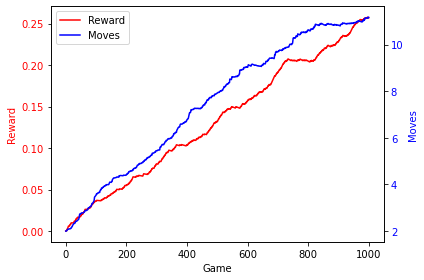

In [6]:
def exp_moving_average(data,alpha):

    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

fig, ax1 = plt.subplots()

ax1.set_xlabel('Game')
ax1.set_ylabel('Reward', color="red")
ax1.plot(exp_moving_average(R_save, 1/1000),color="red",label='Reward')
ax1.tick_params(axis='y', labelcolor="red")

ax2 = ax1.twinx()

ax2.set_ylabel('Moves',color="blue")
ax2.plot(exp_moving_average(N_moves_save, 1/1000),color="blue",label='Moves')
ax2.tick_params(axis='y', labelcolor="blue")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

fig.tight_layout()
plt.show()

In [ ]:
with open("R_q_er_mb1.npy", "wb") as f:
    np.save(f, np.array(R_save))

with open("moves_q_er_mb1.npy", "wb") as f:
    np.save(f, np.array(N_moves_save))